# Creational Patterns

The creational patterns are guidelines suggested to create objects. They provide different mechanisms to create objects in a way that code is flexible, resusable, and easy to maintain.

The five creational patterns available are:
1. Builder
2. Factory
3. Abstract Factory
4. Prototype
5. Singleton

Each of those previous patterns are unique, and can be used in different situations and conditions.

# Builder

**What is a builder?**

A builder is a class that defines how to create an object. 

**Analogy**

If you're creating a robot. It is too much complicated to create a new one. How to create a new object? You have the engineering instructions, and then to put one piece at a time. This is done iteratively until finishing the robot.

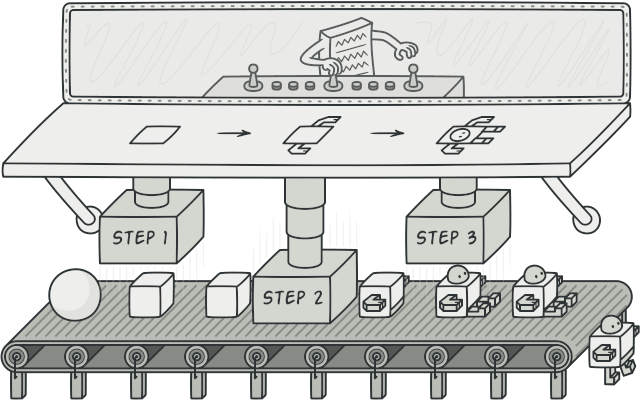

Reference: https://refactoring.guru/design-patterns/builder

**When should we use it?**

This is suggested when we want to create objects that need several spefications. 

**Scenario**

You need to create a pipeline with the following steps:

1. Standard scaler
2. Model fitting

We are going to use a toy dataset about diabetes from sklearn.

In [117]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

import pandas as pd

In [118]:
df = load_diabetes(as_frame=True, return_X_y=True)

In [119]:
df = pd.concat([df[0], df[1]], axis=1)

In [120]:
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


Make an split for train-test

In [121]:
y = df["target"]
x = df.drop(["target"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=99
)

## Antipattern

Well, in this case, I would reproduce how the old version of myself would do it. 

Typically, when learning pipelines in sklearn, it is not explained the best way of coding this. So, I would reproduce as I said previously how most MLEs would do it.

In [122]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

Define the steps

In [123]:
steps = [("standard_scaler", StandardScaler()), ("rf", RandomForestRegressor())]

In [124]:
pipeline_antipattern = Pipeline(steps=steps)

In [125]:
pipeline_antipattern.fit(x_train, y_train)

,steps,"[('standard_scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [126]:
y_pred1 = pipeline_antipattern.predict(x_test)

The pipeline as seen before was fitted and used for making predictions. However, it comes to my mind a question. What if we want to change the `standard_scaler` by a `minmax_scaler`? 

If I would be doing this some time ago, I would copy and paste most of the code. Then, I will only refactor the scaler with the new one.

In [127]:
new_steps = [("minmax_scaler", MinMaxScaler()), ("rf", RandomForestRegressor())]

In [128]:
pipeline_antipattern2 = Pipeline(steps=new_steps)

In [129]:
pipeline_antipattern2.fit(x_train, y_train)

,steps,"[('minmax_scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [130]:
y_pred2 = pipeline_antipattern2.predict(x_test)

As you saw before, everytime I wanted to change something, I would need to write code over and over again. This is a mess, and the code smells. We are following in the Don't Repeat Yourself (DRY) problem.  To avoid this, and follow the pipeline recipe as we want, we need to refactor our code to follow the `Builder` design pattern

## Pattern

**How to solve the antipattern?**

1. Create a class that encapsulates the minimum attributes needed to create the object. In this case, it is the pipeline. (**Object class**)
2. Create a class that encapsulates the methods needed to create an specific object. (**Builder class**)
3. Define a way to connect the connect the `Object` class and the `Builder` class.

### Approach 1

Injecting the `Object` in the `Builder` constructor.

Define the object class

In [131]:
class PipelineDiabetes:
    def __init__(self):
        self.steps = []

Define the builder class

In [132]:
class BuilderPipeline:
    def __init__(self, pipeline: PipelineDiabetes):
        self.pipeline = pipeline

    def add_standard_scaler(self, step_name):
        self.pipeline.steps.append((step_name, StandardScaler()))

    def add_minmax_scaler(self, step_name):
        self.pipeline.steps.append((step_name, MinMaxScaler()))

    def add_random_forest(self):
        self.pipeline.steps.append(("random_forest", RandomForestRegressor()))

    def generate_pipeline(self):
        final_pipeline = Pipeline(self.pipeline.steps)
        # this is do to reset the steps and use the same builder as many timeas as you want
        self.pipeline.steps = []
        return final_pipeline

Now, let's define a builder

In [133]:
builder_pipeline1 = BuilderPipeline(pipeline=PipelineDiabetes())

Based on the builder, we can append any steps as we want. To reproduce the same as the previous cells, we are going to create first a pipeline with a standard scaler, and then other with a minmax scaler.

In [134]:
builder_pipeline1.add_standard_scaler(step_name="standard_scaler")
builder_pipeline1.add_random_forest()

In fact, if you see the steps inside the builder, you'll get

In [135]:
builder_pipeline1.pipeline.steps

[('standard_scaler', StandardScaler()),
 ('random_forest', RandomForestRegressor())]

Now, the builder has defined all the rules in the same way as we want. We need to compile to get the actual object.

In [136]:
pipeline_fixed1 = builder_pipeline1.generate_pipeline()

In [137]:
pipeline_fixed1

,steps,"[('standard_scaler', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


We can even train the pipeline

In [138]:
pipeline_fixed1.fit(x_train, y_train)

,steps,"[('standard_scaler', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [139]:
y_pred3 = pipeline_fixed1.predict(x_test)

*What if we want to create a new pipeline with the minmax scaler?*

Well, as I said before, we don't need to fall into the DRY. Again, we can use the factory to create a new object.

In [141]:
builder_pipeline1.add_minmax_scaler("minmax_scaler")
builder_pipeline1.add_random_forest()

In [142]:
pipeline_fixed2 = builder_pipeline1.generate_pipeline()

In [143]:
pipeline_fixed2

,steps,"[('minmax_scaler', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [144]:
pipeline_fixed2.fit(x_train, y_train)

,steps,"[('minmax_scaler', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [145]:
y_pred4 = pipeline_fixed2.predict(x_test)

### Approach 2

We can expose the builder directly inside the object class by a `property` decorator.

In [148]:
class PipelineDiabetesAlternative:
    def __init__(self):
        self.steps = []

    @property
    def create(self):
        return BuilderPipeline(pipeline=self)

In [149]:
pipeline_approach2 = PipelineDiabetesAlternative()

The `property` decorator allow us to access to a class and their methods similar to access to an attribute of the superior class.

Based on this, we can create the object directly.

In [151]:
pipeline_approach2.create.add_minmax_scaler("minmax_scaler")
pipeline_approach2.create.add_random_forest()

In [154]:
pipeline_approach2 = pipeline_approach2.create.generate_pipeline()

In [156]:
pipeline_approach2

,steps,"[('minmax_scaler', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [157]:
pipeline_approach2.fit(x_train, y_train)

,steps,"[('minmax_scaler', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [158]:
y_pred5 = pipeline_approach2.predict(x_test)

Downsides of this implementation?

- This implementation does not take into account to create a single `Builder` object. Instead of this, a builder is created per `Object`. The final decision is yours to take which best fits to you.